In [1]:
import tekore as tk
import pandas as pd
import random
import numpy as np
from numpy.linalg import norm
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:
def authorize():
    CLIENT_ID = "31c7e9998e1f481796060113de208fd0"
    CLIENT_SECRET = "510c40bad9124d64859730b1c9fb148f"
    app_token = tk.request_client_token(CLIENT_ID, CLIENT_SECRET)
    return tk.Spotify(app_token)

Spotify(token=RefreshingToken(access_token='BQCQaEOzssae4DkUpGbuExrXZDfIJin6ltNFp-BudcXQnrdfg9fjSj5lgKsxzPDgEHfBnjhioPYHCwvEYnLq-vJ2nFkZqjsps-EkRKqOrC-5VEOf3HU', refresh_token=None, scope=Scope('')), max_limits_on=False, chunked_on=False, sender=SyncSender())

In [4]:
sp =authorize()
# Get genres
genres = sp.recommendation_genre_seeds()
# number of recommendations
n_recs = 10
data_dict = {"id":[], "genre":[], "track_name":[], "artist_name":[],
             "valence":[], "energy":[]}

# Get recommendations
for g in tqdm(genres):
    
    recs = sp.recommendations(genres = [g], limit = n_recs)
    recs = eval(recs.json().replace("null", "-999").replace("false", "False").replace("true", "True"))["tracks"]
    for track in recs:
        # ID and Genre
        data_dict["id"].append(track["id"])
        data_dict["genre"].append(g)
        # Metadata
        track_meta = sp.track(track["id"])
        data_dict["track_name"].append(track_meta.name)
        data_dict["artist_name"].append(track_meta.album.artists[0].name)
        # Valence and energy
        track_features = sp.track_audio_features(track["id"])
        data_dict["valence"].append(track_features.valence)
        data_dict["energy"].append(track_features.energy)
        # Wait 0.2 seconds per track so that the api doesnt overheat
        time.sleep(0.2)

df = pd.DataFrame(data_dict)
df.drop_duplicates(subset = "id", keep = "first", inplace = True)

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [09:48<00:00,  4.67s/it]


In [16]:
df["mood_vec"] = df[["valence", "energy"]].values.tolist()
#Get recommended songs based on twisted energy and valence
def recommend(track_id, ref_df, sp, n_recs = 5,energy=1, valence=1):
    track_features = sp.track_audio_features(track_id)
    track_moodvec = np.array([valence*track_features.valence, energy*track_features.energy])
    # Compute distances to all reference tracks
    ref_df["distances"] = ref_df["mood_vec"].apply(lambda x: norm(track_moodvec-np.array(x)))
    # Sort distances from lowest to highest
    ref_df_sorted = ref_df.sort_values(by = "distances", ascending = True)
    ref_df_sorted = ref_df_sorted[ref_df_sorted["id"] != track_id]
    # Return recommendations
    return ref_df_sorted.iloc[:n_recs]

In [218]:
#Get song 'Loose by KSI'
track=sp.track_audio_features("0G9vbgmLrDqjV4NUCSrsIg?si=e6dd0aa286074896")
track

AudioFeatures with fields:
  acousticness = 0.0434
  analysis_url = 'https://api.spotify.com/v1/audio-analysis/0G9vbgmLrDq...'
  danceability = 0.837
  duration_ms = 152436
  energy = 0.624
  id = '0G9vbgmLrDqjV4NUCSrsIg'
  instrumentalness = 0
  key = 1
  liveness = 0.141
  loudness = -4.884
  mode = 1
  speechiness = 0.0763
  tempo = 108.983
  time_signature = 4
  track_href = 'https://api.spotify.com/v1/tracks/0G9vbgmLrDqjV4NUCSrsIg'
  type = 'audio_features'
  uri = 'spotify:track:0G9vbgmLrDqjV4NUCSrsIg'
  valence = 0.725

In [219]:
#Get a similar track with higher energy
rec1=recommend(track_id = mad_world, ref_df = df, sp = sp, n_recs = 1, energy=1.5, valence=1)
rec1
#We see that we got an EDM track

,id,genre,track_name,artist_name,valence,energy,mood_vec,distances
318,3rHFo3c176QQnZ3Ucdbp21,edm,Killin' It,Krewella,0.219,0.909,"[0.219, 0.909]",0.00522


In [220]:
#Get a similar track with lower energy
rec2=recommend(track_id = mad_world, ref_df = df, sp = sp, n_recs = 1, energy= 0.8, valence=1)
rec2
#We see that we got a Latino track

,id,genre,track_name,artist_name,valence,energy,mood_vec,distances
707,4DXdQGLlY6pA6JjYDxFerT,latino,Loco,Enrique Iglesias,0.221,0.509,"[0.221, 0.509]",0.023592


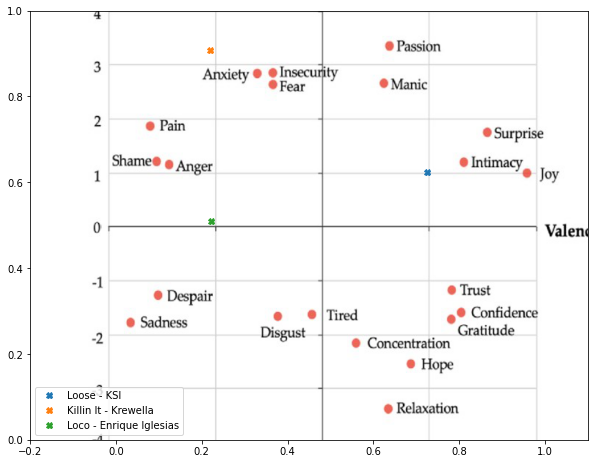

In [221]:
#Plot the Valence-Arousal (Valence-Energy) graph
img = plt.imread("Emotion-Mapping-in-Valence-Arousal-Domains.jpg")
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(img, extent=[-0.2, 1.1, 0, 1])
ax.plot(track.valence, track.energy, 'X', label='Loose - KSI')
ax.plot(rec1.valence, rec1.energy, 'X', label='Killin It - Krewella')
ax.plot(rec2.valence, rec2.energy, 'X', label='Loco - Enrique Iglesias')


plt.legend(loc=3)
plt.show()